In [1]:
# Load in libraries

import warnings
warnings.filterwarnings('ignore')

#libraries for handling data
import pandas as pd
import numpy as np
import math
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

#label encoders
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()


#libraries for data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
%matplotlib inline
import seaborn as sns
sns.set_palette('Set2')

#libaries for modelling
# Regression Modelling Algorithms
import statsmodels.api as sm
#from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor


In [2]:
#train = pd.read_csv("/Users/reejungkim/Documents/Git/Kaggle---House-Price/train.csv", index_col=0)
train = pd.read_csv("https://raw.githubusercontent.com/reejungkim/HousingPrice/master/train.csv", error_bad_lines=False)
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
#test = pd.read_csv('/Users/reejungkim/Documents/Git/Kaggle---House-Price/test.csv', index_col=0)
test = pd.read_csv("https://raw.githubusercontent.com/reejungkim/HousingPrice/master/test.csv", error_bad_lines=False)
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [4]:
test.shape, train.shape

((1459, 80), (1460, 81))

train.describe().transpose()

In [5]:
all_data = pd.concat((train,test))

In [6]:
all_data.shape

(2919, 81)

## EDA

In [7]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

#### columns with highest missing value portions

In [8]:
(all_data.isnull().sum()/ len(all_data)).sort_values(ascending=False)[:30]

PoolQC          0.996574
MiscFeature     0.964029
Alley           0.932169
Fence           0.804385
SalePrice       0.499829
FireplaceQu     0.486468
LotFrontage     0.166495
GarageQual      0.054471
GarageYrBlt     0.054471
GarageFinish    0.054471
GarageCond      0.054471
GarageType      0.053786
BsmtExposure    0.028092
BsmtCond        0.028092
BsmtQual        0.027749
BsmtFinType2    0.027407
BsmtFinType1    0.027064
MasVnrType      0.008222
MasVnrArea      0.007879
MSZoning        0.001370
Utilities       0.000685
Functional      0.000685
BsmtFullBath    0.000685
BsmtHalfBath    0.000685
GarageArea      0.000343
BsmtFinSF2      0.000343
Exterior1st     0.000343
TotalBsmtSF     0.000343
GarageCars      0.000343
BsmtUnfSF       0.000343
dtype: float64

#### colums whose missing portions are greater than 80%

In [9]:
df_null = pd.DataFrame((all_data.isnull().sum()/ len(all_data)), columns={"%missing"})
df_null.loc[df_null['%missing']>=.8]

,%missing
Alley,0.932169
PoolQC,0.996574
Fence,0.804385
MiscFeature,0.964029


#### Question: Should we drop and not use the data where there're more than 80% of data missing(NA)?
Per data description, the NA for those four features above means zero (0) instead of missing. So, we should NOT drop them at this stage.

Alley: Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access
       
       

PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool
       
       
       
Fence: Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence
	
MiscFeature: Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None


# handling null values

In [10]:
# Null values of Electrical and Total BsmtSF would be replaced by mode
for col in ['Electrical', 'RoofStyle', 'Neighborhood']:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [11]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

all_data.loc[pd.isnull(all_data.LotFrontage)]

In [12]:
#all_data.iloc[:,all_data.dtypes==object]
a = all_data.select_dtypes(include=['object']).columns
a

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [13]:
#replace all null values to 0
for col in a:
    all_data[col] = all_data[col].fillna('None')

In [14]:
b = all_data.select_dtypes(include=['int64', 'float64']).columns
b

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [15]:
all_data['LotFrontage'].dtype

dtype('float64')

In [16]:
# Null values of rest of numerical types variables would better be replaced by median of neighborhood group
for col in b:
    all_data[col] = all_data.groupby('Neighborhood')[col].transform( lambda x: x.fillna(x.median()))
 

In [17]:
all_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000.0


# vectorization/ Encoding

In [18]:
for col in a:
    print('{}: {}'.format(col, all_data[col].unique()  ))

MSZoning: ['RL' 'RM' 'C (all)' 'FV' 'RH' 'None']
Street: ['Pave' 'Grvl']
Alley: ['None' 'Grvl' 'Pave']
LotShape: ['Reg' 'IR1' 'IR2' 'IR3']
LandContour: ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities: ['AllPub' 'NoSeWa' 'None']
LotConfig: ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope: ['Gtl' 'Mod' 'Sev']
Neighborhood: ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Condition1: ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Condition2: ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
BldgType: ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle: ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle: ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
RoofMatl: ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTile']


In [19]:
#x = le.fit_transform(all_data['Alley'].unique())
#y = le.inverse_transform(x)
#list(x), list(y)

In [20]:
#Encoding object type variables using label encoder
for col in a:
    all_data[col] = le.fit_transform(all_data[col])

In [21]:
all_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,4,65.0,8450,1,1,3,3,0,...,0,3,4,1,0,2,2008,9,4,208500.0
1,2,20,4,80.0,9600,1,1,3,3,0,...,0,3,4,1,0,5,2007,9,4,181500.0
2,3,60,4,68.0,11250,1,1,0,3,0,...,0,3,4,1,0,9,2008,9,4,223500.0
3,4,70,4,60.0,9550,1,1,0,3,0,...,0,3,4,1,0,2,2006,9,0,140000.0
4,5,60,4,84.0,14260,1,1,0,3,0,...,0,3,4,1,0,12,2008,9,4,250000.0


In [22]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2919 non-null   int64  
 3   LotFrontage    2919 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   int64  
 6   Alley          2919 non-null   int64  
 7   LotShape       2919 non-null   int64  
 8   LandContour    2919 non-null   int64  
 9   Utilities      2919 non-null   int64  
 10  LotConfig      2919 non-null   int64  
 11  LandSlope      2919 non-null   int64  
 12  Neighborhood   2919 non-null   int64  
 13  Condition1     2919 non-null   int64  
 14  Condition2     2919 non-null   int64  
 15  BldgType       2919 non-null   int64  
 16  HouseStyle     2919 non-null   int64  
 17  OverallQual    2919 non-null   int64  
 18  OverallC

# Scaler

In [23]:
#choose scaler
scaler = RobustScaler()

In [24]:
#scaler application
scaled_X = scaler.fit_transform(all_data.loc[:, all_data.columns!='SalePrice'].reset_index(drop=True))
scaled_Y = scaler.fit_transform( all_data[0:1460][['SalePrice']] )  

In [25]:
scaled_Y

array([[ 0.5415055 ],
       [ 0.22017257],
       [ 0.7200238 ],
       ...,
       [ 1.23177626],
       [-0.24843796],
       [-0.18446891]])

<AxesSubplot:ylabel='Density'>

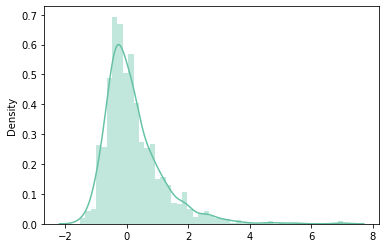

In [26]:
sns.distplot(scaled_Y)

# set x_train, y_train, x_test, and y_test

In [27]:
x_train = scaled_X[0:1460]
y_train = scaled_Y[0:1460]
x_test = scaled_X[1460::]
y_test = scaled_Y[1460::]

In [28]:
#linear regression
#lm = LinearRegression()
#lm.fit(x_train, y_train)
#y_pred_lm = lm.predict(x_test)
#lm.score(x_train, y_train) 


lm = sm.OLS(y_train, x_train).fit() ## sm.OLS(output, input)
y_pred_lm = lm.predict(x_test)

# Print out the statistics
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     102.0
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        20:19:32   Log-Likelihood:                -594.29
No. Observations:                1460   AIC:                             1347.
Df Residuals:                    1381   BIC:                             1764.
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0271      0.035     -0.774      0.439      -0.096       0.042
x2            -0.0647      0.027     -2.411      0.016      -0.117      -0.012
x3            -0.0026      0.015     -0.175      0.861      -0.031       0.026
x4            -0.0407      0.012     -3.403      0.001      -0.064      -0.017
x5             0.0199      0.005      3.849      0.000       0.010       0.030
x6             0.3544      0.166      2.134      0.033       0.029       0.680
x7             0.0305      0.044      0.687      0.492      -0.057       0.118
x8            -0.0310      0.023     -1.328      0.184      -0.077       0.015
x9             0.0358      0.016      2.255      0.024       0.005       0.067
x10           -0.6623      0.392     -1.689      0.092      -1.432       0.107
x11         3.491e-05      0.013      0.003      0.998      -0.025       0.025
x12            0.0703      0.045      1.553      0.121      -0.018       0.159
x13            0.0500      0.018      2.713      0.007       0.014       0.086
x14           -0.0113      0.012     -0.944      0.346      -0.035       0.012
x15           -0.1114      0.040     -2.811      0.005      -0.189      -0.034
x16           -0.0383      0.018     -2.161      0.031      -0.073      -0.004
x17           -0.0382      0.023     -1.644      0.100      -0.084       0.007
x18            0.2608      0.028      9.291      0.000       0.206       0.316
x19            0.0620      0.012      5.008      0.000       0.038       0.086
x20            0.1420      0.045      3.169      0.002       0.054       0.230
x21            0.0004      0.032      0.012      0.991      -0.062       0.062
x22            0.0226      0.013      1.696      0.090      -0.004       0.049
x23            0.0620      0.018      3.475      0.001       0.027       0.097
x24           -0.0550      0.028     -1.996      0.046      -0.109      -0.001
x25            0.0262      0.030      0.866      0.386      -0.033       0.085
x26            0.0573      0.019      3.035      0.002       0.020       0.094
x27            0.0693      0.012      5.847      0.000       0.046       0.093
x28           -0.1343      0.023     -5.796      0.000      -0.180      -0.089
x29            0.0098      0.015      0.658      0.511      -0.019       0.039
x30            0.0167      0.020      0.858      0.391      -0.022       0.055
x31           -0.1035      0.024     -4.253      0.000      -0.151      -0.056
x32            0.0155      0.011      1.354      0.176      -0.007       0.038
x33           -0.0441      0.010     -4.220      0.000      -0.065      -0.024
x34           -0.0341      0.024     -1.393      0.164      -0.082       0.014
x35           -0.0263      0.039     -0.682      0.496      -0.102       0.049
x36            0.0073      0.012      0.584      0.559      -0.017       0.032
x3

In [29]:
#random forest regression
randomForest = RandomForestRegressor()
randomForest.fit(x_train, y_train)
y_pred_randomForest = randomForest.predict(x_test)

print("Train score: %0.3f" % randomForest.score(x_train, y_train) )

Train score: 0.981


In [30]:
#support vector regression
svr = SVR()
svr.fit(x_train, y_train)
y_pred_svr = svr.predict(x_test)

print("Train score: %0.3f" % svr.score(x_train, y_train) )

Train score: 0.086


In [31]:
#gradient boosting regression
gradientBoosting = GradientBoostingRegressor()
gradientBoosting.fit(x_train, y_train)
y_pred_gradBoost = gradientBoosting.predict(x_test)

print("Train score: %0.3f" % gradientBoosting.score(x_train, y_train))

Train score: 0.965


In [32]:
from sklearn.model_selection import RandomizedSearchCV
#from sklearn.model_selection import GridSearchCV

# First create the base model to tune
rfr = RandomForestRegressor() #RandomForestRegressor()


# Number of trees in random forest
n_estimators = [3000] #[int(x) for x in np.linspace(start = 500, stop = 1000, num = 3)]
# Number of features to consider at every split
max_features = ['sqrt'] #['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [6, 8 , 10]#[int(x) for x in np.linspace(10, 110, num = 11)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [8, 12, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [8, 16, 20]
# Method of selecting samples for training each tree
bootstrap = [True] #[True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfr_random = RandomizedSearchCV(estimator = rfr, 
                               param_distributions = random_grid, 
                               #n_iter = 5, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)


#clf = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=5,n_jobs=-1, verbose=1)

In [33]:
# Fit the random search model
rfr_random.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   36.3s finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [6, 8, 10],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [8, 16, 20],
                                        'min_samples_split': [8, 12, 20],
                                        'n_estimators': [3000]},
                   random_state=42, verbose=2)

In [35]:
rfr_random.score(x_train, y_train)

0.8787905119287329

In [53]:
rfr_random.score(x_test, y_pred)

1.0

In [36]:
rfr_random.best_params_

{'n_estimators': 3000,
 'min_samples_split': 8,
 'min_samples_leaf': 8,
 'max_features': 'sqrt',
 'max_depth': 8,
 'bootstrap': True}

# inverse scaler

In [37]:
# predictions
y_pred = rfr_random.predict(x_test)
y_pred

array([-0.38302205, -0.12637157,  0.23947851, ..., -0.01525186,
       -0.45236851,  0.76717323])

y_pred = y_pred_randomForest

In [40]:
y_new_inverse = scaler.inverse_transform(y_pred.reshape(-1,1))

In [41]:
y_new_inverse

array([[130816.5724627 ],
       [152381.62849675],
       [183122.18175244],
       ...,
       [161718.46223778],
       [124989.73573792],
       [227461.73078913]])

In [42]:
y_new_inverse = np.squeeze(y_new_inverse)

In [43]:
y_new_inverse.shape

(1459,)

In [44]:
all_data.reset_index()['Id'][1460::].values.shape

(1459,)

In [45]:
Id = (all_data.reset_index()['Id'][1460::]).values
result = pd.DataFrame( { 'Id': Id , 'SalePrice': y_new_inverse} )

In [46]:
result

,Id,SalePrice
0,1461,130816.572463
1,1462,152381.628497
2,1463,183122.181752
3,1464,187021.597512
4,1465,198503.437936
...,...,...
1454,2915,94787.394980
1455,2916,100977.795618
1456,2917,161718.462238
1457,2918,124989.735738


In [47]:
#Export result as a csv file
import os
os.getcwd()

result.to_csv( 'Submission.csv' , index = False )

# check feature importance

In [48]:
features = all_data.loc[:, all_data.columns!='SalePrice'].columns
importances = randomForest.feature_importances_

<AxesSubplot:>

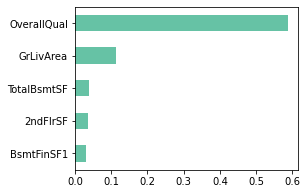

In [49]:
feat_importances = pd.Series(importances, index=features)

#feat_importances.sort_values(ascending=True).plot(kind='barh', figsize=(10, 20))
#feat_importances.nlargest(5).sort_values(ascending=True).plot(kind='barh')
feat_importances.nlargest(5).sort_values(ascending=True).plot(kind='barh', figsize=(4, 3))

In [50]:
dfFeatures = pd.DataFrame(feat_importances.nlargest(5), columns=['importance'])
dfFeatures

,importance
OverallQual,0.586402
GrLivArea,0.112768
TotalBsmtSF,0.038099
2ndFlrSF,0.035681
BsmtFinSF1,0.029247
